In [2]:
import torch

state_dict = torch.load(
    "vae_celeba_latent_200_epochs_10_batch_64_subset_80000.pth",
    map_location="cpu"
)

for key, val in state_dict.items():
    print(f"{key:40s} {val.shape}")


encoder.0.weight                         torch.Size([32, 3, 4, 4])
encoder.0.bias                           torch.Size([32])
encoder.2.weight                         torch.Size([64, 32, 4, 4])
encoder.2.bias                           torch.Size([64])
encoder.4.weight                         torch.Size([128, 64, 4, 4])
encoder.4.bias                           torch.Size([128])
encoder.6.weight                         torch.Size([256, 128, 4, 4])
encoder.6.bias                           torch.Size([256])
fc_mu.weight                             torch.Size([200, 4096])
fc_mu.bias                               torch.Size([200])
fc_logvar.weight                         torch.Size([200, 4096])
fc_logvar.bias                           torch.Size([200])
decoder_input.weight                     torch.Size([4096, 200])
decoder_input.bias                       torch.Size([4096])
decoder.0.weight                         torch.Size([256, 128, 4, 4])
decoder.0.bias                           torch.Si

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class VAE(nn.Module):
    def __init__(self, latent_dim=200):
        super(VAE, self).__init__()

        # Encoder: 4 Conv2d layers with stride=2, kernel=4, padding=1
        # Input: (3, 64, 64) -> (32, 32, 32) -> (64, 16, 16) -> (128, 8, 8) -> (256, 4, 4)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),    # 0
            nn.ReLU(),                                                # 1
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),   # 2
            nn.ReLU(),                                                # 3
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 4
            nn.ReLU(),                                                # 5
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # 6
            nn.ReLU(),                                                # 7
        )

        # 256 * 4 * 4 = 4096
        self.fc_mu = nn.Linear(4096, latent_dim)
        self.fc_logvar = nn.Linear(4096, latent_dim)

        # Decoder input
        self.decoder_input = nn.Linear(latent_dim, 4096)

        # Decoder: 4 ConvTranspose2d layers
        # (256, 4, 4) -> (128, 8, 8) -> (64, 16, 16) -> (32, 32, 32) -> (3, 64, 64)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 0
            nn.ReLU(),                                                          # 1
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 2
            nn.ReLU(),                                                          # 3
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 4
            nn.ReLU(),                                                          # 5
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),     # 6
            nn.Sigmoid(),                                                       # 7
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten to (batch, 4096)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(x.size(0), 256, 4, 4)  # Reshape to (batch, 256, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [5]:
import torch
# from vae_model import VAE  # Ensure the VAE class is defined in vae_model.py
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define the latent dimension
latent_dim = 200

# Initialize the model
model = VAE(latent_dim=latent_dim)

# Load the trained weights
model_path = "./vae_celeba_latent_200_epochs_10_batch_64_subset_80000.pth"
model.load_state_dict(torch.load(model_path))
model.to(device)
print (model)


VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (fc_mu): Linear(in_features=4096, out_features=200, bias=True)
  (fc_logvar): Linear(in_features=4096, out_features=200, bias=True)
  (decoder_input): Linear(in_features=200, out_features=4096, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2)

TEST 1: Generating random faces...


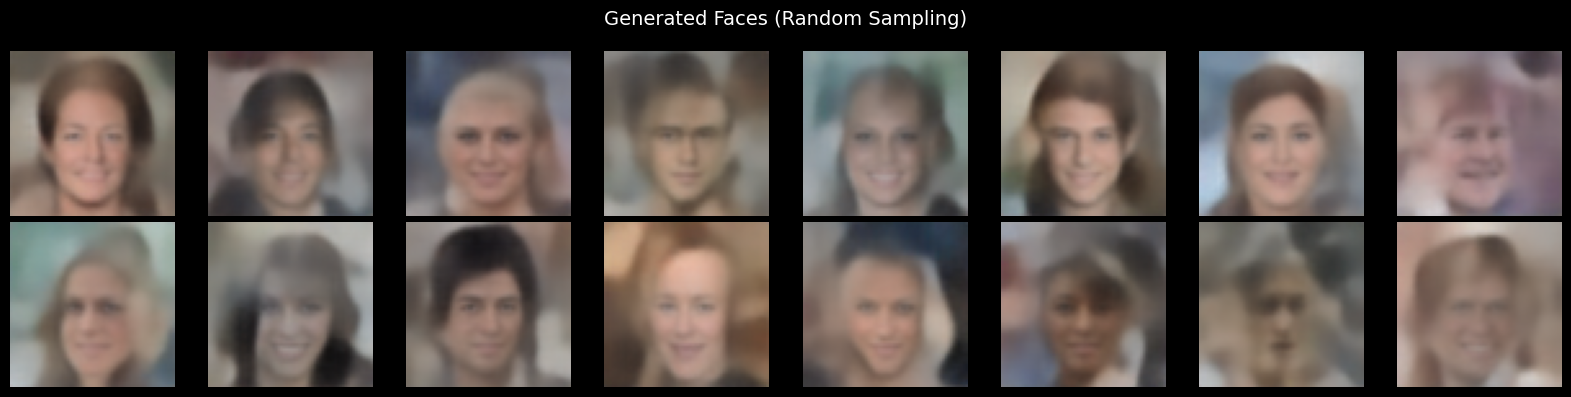

Saved: generated_faces.png

TEST 2: Reconstruction...


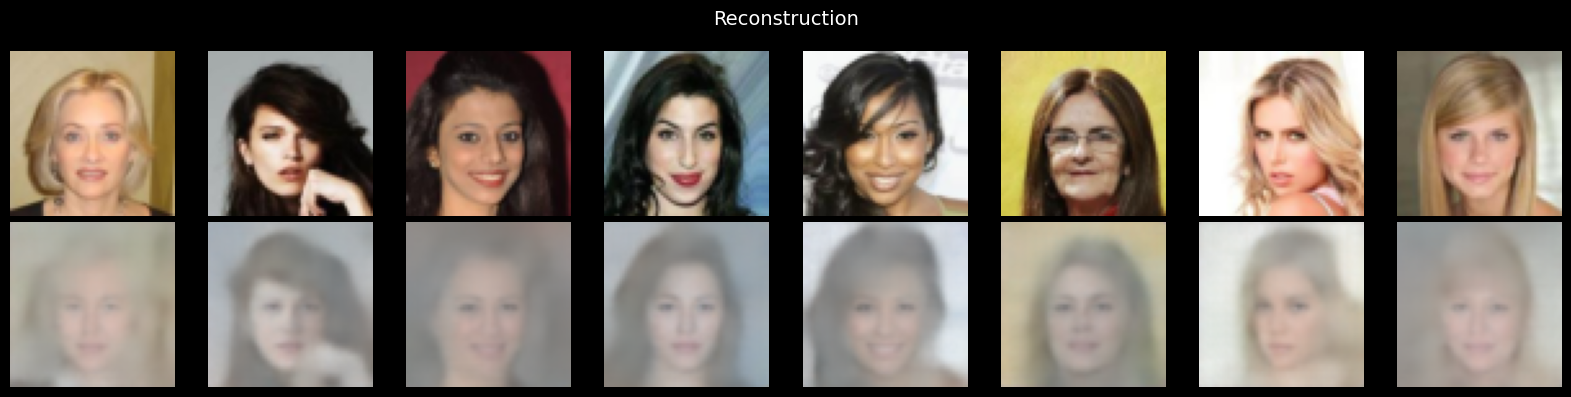

Saved: reconstruction.png


In [10]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load Model ---
latent_dim = 200
model = VAE(latent_dim=latent_dim)
model.load_state_dict(torch.load(
    "./vae_celeba_latent_200_epochs_10_batch_64_subset_80000.pth",
    map_location=device
))
model.to(device)
model.eval()

# --- Helper: convert tensor to displayable image ---
def to_img(tensor):
    """Convert a (C, H, W) tensor to (H, W, C) numpy array for display."""
    img = tensor.detach().cpu().clamp(0, 1).permute(1, 2, 0).numpy()
    return img


# ============================================================
# TEST 1: Generate random faces from latent space
# ============================================================
def generate_faces(n=16):
    with torch.no_grad():
        z = torch.randn(n, latent_dim).to(device)
        generated = model.decode(z)

    cols = min(n, 8)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = np.array(axes).flatten()
    for i in range(n):
        axes[i].imshow(to_img(generated[i]))
        axes[i].axis("off")
    for i in range(n, len(axes)):
        axes[i].axis("off")
    plt.suptitle("Generated Faces (Random Sampling)", fontsize=14)
    plt.tight_layout()
    plt.savefig("generated_faces.png", dpi=150)
    plt.show()
    print("Saved: generated_faces.png")


# ============================================================
# TEST 2: Reconstruct images from CelebA dataset
# ============================================================
def reconstruct_faces(n=8):
    transform = transforms.Compose([
        transforms.CenterCrop(178),
        transforms.Resize(64),
        transforms.ToTensor(),
    ])

    # Download CelebA or load from local path
    # Option A: torchvision CelebA (may need manual download)
    dataset = datasets.ImageFolder(root="./data/celeba", transform=transform)

    # dataset = datasets.CelebA(root="./data", split="test", transform=transform, download=True)
    loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)
    real_images, _ = next(iter(loader))  # grab one batch
    real_images = real_images.to(device)

    # Option B: Load images from a folder
    # dataset = datasets.ImageFolder(root="./celeba_images", transform=transform)

    # For quick testing without CelebA, use random noise as input:
    # print("Using random images as input (replace with CelebA for real results)")
    # fake_images = torch.rand(n, 3, 64, 64).to(device)

    with torch.no_grad():
        recon, mu, logvar = model(real_images)

    fig, axes = plt.subplots(2, n, figsize=(n * 2, 4))
    for i in range(n):
        axes[0, i].imshow(to_img(real_images[i]))
        axes[0, i].axis("off")
        axes[1, i].imshow(to_img(recon[i]))
        axes[1, i].axis("off")
    axes[0, 0].set_ylabel("Original", fontsize=12)
    axes[1, 0].set_ylabel("Reconstructed", fontsize=12)
    plt.suptitle("Reconstruction", fontsize=14)
    plt.tight_layout()
    plt.savefig("reconstruction.png", dpi=150)
    plt.show()
    print("Saved: reconstruction.png")



# ============================================================
# Run all tests
# ============================================================
if __name__ == "__main__":
    print("=" * 50)
    print("TEST 1: Generating random faces...")
    print("=" * 50)
    generate_faces(16)

    print("\n" + "=" * 50)
    print("TEST 2: Reconstruction...")
    print("=" * 50)
    reconstruct_faces(8)



In [14]:
# print the weights of a specific layer
weights_selected_layer = [param for name, param in model.named_parameters() if name == "decoder.6.weight"][0]

selected_weights = torch.flatten(weights_selected_layer.mean(dim=0))
print(selected_weights.shape)

torch.Size([48])


In [20]:
for name, param in model.named_parameters():
    print(name, param.shape)

    #weight size in decoder.6    =  32*3*4*4 = 1536
    #featuer map size in decoder.6 out = 3*64*64 = 12288

encoder.0.weight torch.Size([32, 3, 4, 4])
encoder.0.bias torch.Size([32])
encoder.2.weight torch.Size([64, 32, 4, 4])
encoder.2.bias torch.Size([64])
encoder.4.weight torch.Size([128, 64, 4, 4])
encoder.4.bias torch.Size([128])
encoder.6.weight torch.Size([256, 128, 4, 4])
encoder.6.bias torch.Size([256])
fc_mu.weight torch.Size([200, 4096])
fc_mu.bias torch.Size([200])
fc_logvar.weight torch.Size([200, 4096])
fc_logvar.bias torch.Size([200])
decoder_input.weight torch.Size([4096, 200])
decoder_input.bias torch.Size([4096])
decoder.0.weight torch.Size([256, 128, 4, 4])
decoder.0.bias torch.Size([128])
decoder.2.weight torch.Size([128, 64, 4, 4])
decoder.2.bias torch.Size([64])
decoder.4.weight torch.Size([64, 32, 4, 4])
decoder.4.bias torch.Size([32])
decoder.6.weight torch.Size([32, 3, 4, 4])
decoder.6.bias torch.Size([3])


In [21]:
# Storage for feature maps
feature_maps = {}

def get_hook(name):
    def hook_fn(module, input, output):
        feature_maps[name] = {
            # 'input': input[0].detach(),
            'output': output.detach()
        }
    return hook_fn

# Register hook on decoder.6
hook = model.decoder[6].register_forward_hook(get_hook('decoder.6'))

# Run a forward pass
img = torch.randn(1, 3, 64, 64).to(device)
with torch.no_grad():
    recon, mu, logvar = model(img)

# Access feature maps
# fm_input = feature_maps['decoder.6']['input']    # torch.Size([1, 32, 32, 32])
fm_output = feature_maps['decoder.6']['output']  # torch.Size([1, 3, 64, 64])

print("Input feature map:", fm_input.shape)
print("Output feature map:", fm_output.shape)

# Don't forget to remove when done
hook.remove()

Input feature map: torch.Size([1, 32, 32, 32])
Output feature map: torch.Size([1, 3, 64, 64])


In [22]:
def get_feature_map(model, img, layer):
    output = None

    def hook_fn(module, input, out):
        nonlocal output
        output = out.detach()

    hook = layer.register_forward_hook(hook_fn)
    with torch.no_grad():
        model(img)
    hook.remove()

    return output

# Usage
img = torch.randn(5, 3, 64, 64).to(device)
fm = get_feature_map(model, img, model.decoder[6])
print(fm.shape)  # torch.Size([1, 3, 64, 64])

fm = get_feature_map(model, img, model.decoder[4])
print(fm.shape)  # torch.Size([1, 32, 32, 32])

torch.Size([5, 3, 64, 64])
torch.Size([5, 32, 32, 32])
